# Processing a dataset on commercial nuclear reactors

Obtained from https://catalog.data.gov/dataset/us-commercial-nuclear-power-reactors.

In [1]:
import csv
import os
import ast
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import IPython
from sklearn import linear_model # for training a linear model
%matplotlib inline

pd.set_option('display.max_columns', None)

### 1. Importing the data

*Note that I manually dropped the first row, which was just a title for the whole document. This allowed me to use the given row names on row 2.*

In [2]:
df = pd.read_excel("/Users/bracho/Downloads/reactors-operating.xls")
df.head()

,"Plant Name, Unit Number",NRC Reactor Unit Web Page,Docket Number,License Number,Location,NRC Region,Licensee,Parent Company Utility Name,Parent Company Website,Parent Company Notes,Reactor and Containment Type,Nuclear Steam System Supplier and Design Type,Architect-Engineer,Constructor,Construction Permit Issued,Operating License Issued,Commercial Operation,Renewed Operating License Issued,Operating License Expires,Licensed MWt,Note,2018 Capacity Factor\n(Percent),2017 Capacity Factor\n(Percent),2016 Capacity Factor\n(Percent),2015 Capacity Factor (Percent),2014 Capacity Factor (Percent),2013 Capacity Factor (Percent),2012 Capacity Factor (Percent),2011 Capacity Factor (Percent),2010 Capacity Factor (Percent),2009 Capacity Factor (Percent),2008 Capacity Factor (Percent),Unnamed: 32,2005 Capacity Factor (Percent),2004 Capacity Factor (Percent),2003 Capacity Factor (Percent),Unnamed: 36,Years of Operation through 12/31/2019,Unnamed: 38
0,"Arkansas Nuclear One, Unit 1",ANO 1,05000313,DPR-51,"London, AR (6 MI WNW of Russellville, AR)",4,"Entergy Operations, Inc.","Entergy Nuclear Operations, Inc.",www.entergy-nuclear.com,NaN,PWR-DRYAMB,B&W LLP,BECH,BECH,1968-12-06,1974-05-21,1974-12-19,2001-06-20 00:00:00,2034-05-20,2568.0,NaN,0.764,0.869083,0.716628,0.823804,0.98,0.560015,1.02,0.87,0.90,0.99,0.830000,NaN,0.78,0.92,0.92,NaN,45,NaT
1,"Arkansas Nuclear One, Unit 2",ANO 2,05000368,NPF-6,"London, AR (6 MI WNW of Russellville, AR)",4,"Entergy Operations, Inc.","Entergy Nuclear Operations, Inc.",www.entergy-nuclear.com,NaN,PWR-DRYAMB,CE,BECH,BECH,1972-12-06,1978-09-01,1980-03-26,2005-06-30 00:00:00,2038-07-17,3026.0,NaN,0.815,0.704106,0.938457,0.886280,0.85,0.909777,0.93,0.90,0.97,0.90,0.911003,NaN,0.91,0.99,0.90,NaN,41,2019-12-31
2,"Beaver Valley Power Station, Unit 1",Beaver Valley 1,05000334,DPR-66,"Shippingport, PA(17 MI W of McCandless, PA)",1,FirstEnergy Nuclear Operating Co.,FirstEnergy Nuclear Operating Company,www.firstenergycorp.com,NaN,PWR-DRYAMB,WEST 3LP,S&W,S&W,1970-06-26,1976-07-02,1976-10-01,2009-11-05 00:00:00,2036-01-29,2900.0,NaN,0.916,0.989327,0.909178,0.900649,0.86,0.860891,0.92,1.01,0.91,0.92,1.014076,NaN,1.01,0.93,0.83,NaN,43,NaT
3,"Beaver Valley Power Station, Unit 2",Beaver Valley 2,05000412,NPF-73,"Shippingport, PA (17 MI W of McCandless, PA)",1,FirstEnergy Nuclear Operating Co.,FirstEnergy Nuclear Operating Company,www.firstenergycorp.com,NaN,PWR-DRYAMB,WEST 3LP,S&W,S&W,1974-05-03,1987-08-14,1987-11-17,2009-11-05 00:00:00,2047-05-27,2900.0,NaN,0.901,0.904377,0.973156,0.897360,0.98,0.966991,0.91,1.02,0.84,0.87,1.030000,NaN,0.93,1.00,0.91,NaN,32,NaT
4,"Braidwood Station, Unit 1",Braidwood 1,05000456,NPF-72,"Braceville, IL (20 MI SSW of Joliet, IL)",3,"Exelon Generation Co., LLC","Exelon Corporation, LLC",www.exeloncorp.com,NaN,PWR-DRYAMB,WEST 4LP,S&L,CWE,1975-12-31,1987-07-02,1988-07-29,2016-01-27 00:00:00,2046-10-17,3645.0,NaN,0.929,0.981952,0.896724,0.931354,1.03,0.950000,0.91,1.01,0.89,0.95,1.013985,NaN,1.00,0.95,0.97,NaN,32,NaT


### 2. Data processing

#### 2.1 Fixing header titles

Inside some of the column names, there are new lines and other unused columns. Thus, we can remove unnecessary columns and fix the names to be more computer-friendly. In addition, because there are many unused columns with "Unnamed" in their title, we can remove them along with their data.

Some headers also contain extraneous spaces at the end of their name, so we can remove them.

In [3]:
headers = [s.replace("\n", " ").strip() for s in list(df)] # Get headers and replace \n
df = df.rename(columns=dict(zip(list(df), headers))) # Rename headers in df
del_col = [s for s in list(df) if "Unnamed" in s] # Find headers with "Unnamed" in name
df = df.drop(del_col, axis=1) # Remove headers in del_col
df.head()

,"Plant Name, Unit Number",NRC Reactor Unit Web Page,Docket Number,License Number,Location,NRC Region,Licensee,Parent Company Utility Name,Parent Company Website,Parent Company Notes,Reactor and Containment Type,Nuclear Steam System Supplier and Design Type,Architect-Engineer,Constructor,Construction Permit Issued,Operating License Issued,Commercial Operation,Renewed Operating License Issued,Operating License Expires,Licensed MWt,Note,2018 Capacity Factor (Percent),2017 Capacity Factor (Percent),2016 Capacity Factor (Percent),2015 Capacity Factor (Percent),2014 Capacity Factor (Percent),2013 Capacity Factor (Percent),2012 Capacity Factor (Percent),2011 Capacity Factor (Percent),2010 Capacity Factor (Percent),2009 Capacity Factor (Percent),2008 Capacity Factor (Percent),2005 Capacity Factor (Percent),2004 Capacity Factor (Percent),2003 Capacity Factor (Percent),Years of Operation through 12/31/2019
0,"Arkansas Nuclear One, Unit 1",ANO 1,05000313,DPR-51,"London, AR (6 MI WNW of Russellville, AR)",4,"Entergy Operations, Inc.","Entergy Nuclear Operations, Inc.",www.entergy-nuclear.com,NaN,PWR-DRYAMB,B&W LLP,BECH,BECH,1968-12-06,1974-05-21,1974-12-19,2001-06-20 00:00:00,2034-05-20,2568.0,NaN,0.764,0.869083,0.716628,0.823804,0.98,0.560015,1.02,0.87,0.90,0.99,0.830000,0.78,0.92,0.92,45
1,"Arkansas Nuclear One, Unit 2",ANO 2,05000368,NPF-6,"London, AR (6 MI WNW of Russellville, AR)",4,"Entergy Operations, Inc.","Entergy Nuclear Operations, Inc.",www.entergy-nuclear.com,NaN,PWR-DRYAMB,CE,BECH,BECH,1972-12-06,1978-09-01,1980-03-26,2005-06-30 00:00:00,2038-07-17,3026.0,NaN,0.815,0.704106,0.938457,0.886280,0.85,0.909777,0.93,0.90,0.97,0.90,0.911003,0.91,0.99,0.90,41
2,"Beaver Valley Power Station, Unit 1",Beaver Valley 1,05000334,DPR-66,"Shippingport, PA(17 MI W of McCandless, PA)",1,FirstEnergy Nuclear Operating Co.,FirstEnergy Nuclear Operating Company,www.firstenergycorp.com,NaN,PWR-DRYAMB,WEST 3LP,S&W,S&W,1970-06-26,1976-07-02,1976-10-01,2009-11-05 00:00:00,2036-01-29,2900.0,NaN,0.916,0.989327,0.909178,0.900649,0.86,0.860891,0.92,1.01,0.91,0.92,1.014076,1.01,0.93,0.83,43
3,"Beaver Valley Power Station, Unit 2",Beaver Valley 2,05000412,NPF-73,"Shippingport, PA (17 MI W of McCandless, PA)",1,FirstEnergy Nuclear Operating Co.,FirstEnergy Nuclear Operating Company,www.firstenergycorp.com,NaN,PWR-DRYAMB,WEST 3LP,S&W,S&W,1974-05-03,1987-08-14,1987-11-17,2009-11-05 00:00:00,2047-05-27,2900.0,NaN,0.901,0.904377,0.973156,0.897360,0.98,0.966991,0.91,1.02,0.84,0.87,1.030000,0.93,1.00,0.91,32
4,"Braidwood Station, Unit 1",Braidwood 1,05000456,NPF-72,"Braceville, IL (20 MI SSW of Joliet, IL)",3,"Exelon Generation Co., LLC","Exelon Corporation, LLC",www.exeloncorp.com,NaN,PWR-DRYAMB,WEST 4LP,S&L,CWE,1975-12-31,1987-07-02,1988-07-29,2016-01-27 00:00:00,2046-10-17,3645.0,NaN,0.929,0.981952,0.896724,0.931354,1.03,0.950000,0.91,1.01,0.89,0.95,1.013985,1.00,0.95,0.97,32


Because the `Parent Company Notes` and `Note` columns contains NaN values for most entries and non-numeric values for the rest, it is safe to drop. In addition, the `Parent Company Website` is redundant information given the `Parent Company Utility Name` column, so it is also safe to drop.

In [4]:
df = df.drop(["Parent Company Notes", "Parent Company Website", "Note"], axis=1)

#### 2.2 Converting date formats

In order to convert the dates in the data into interval form, we calculate date as the number of days since Jan. 1, 1900. This allows the date to be represented as an integer and possibly inputted into models as is.

In [5]:
date_cols = ["Construction Permit Issued", "Operating License Issued", "Commercial Operation", "Renewed Operating License Issued", "Operating License Expires"]
for dc in date_cols:
    repl = []
    for elem in df[dc]:
        try:
            repl.append((pd.Timestamp(elem) - np.datetime64('1900-01-01')).days)
        except:
            repl.append(np.nan)
    df[dc] = repl

#### 2.3 One-hot encoding for reactor type and containment

Note that the column "Reactor and Containment Type" contains a string separated by a hyphen, with the first type (BWR/PWR) indicating reactor type and the second part (DRYAMB/ICECND/MARK 1/MARK 2/MARK 3) indicating containment type. We can convert this information into a one-hot encoding below.

In [6]:
reactor_type_columns = ["BWR", "PWR"]
containment_type_columns = ["DRYAMB", "ICECND", "MARK1", "MARK2", "MARK3"]

def name_to_one_hot_reactor(t):
    return [(q in t) for q in reactor_type_columns]

def name_to_one_hot_containment(t):
    return [(q in t) for q in containment_type_columns]

df['RT_mapped'] = df['Reactor and Containment Type'].apply(name_to_one_hot_reactor)
df['CT_mapped'] = df['Reactor and Containment Type'].apply(name_to_one_hot_containment)
df.head()

,"Plant Name, Unit Number",NRC Reactor Unit Web Page,Docket Number,License Number,Location,NRC Region,Licensee,Parent Company Utility Name,Reactor and Containment Type,Nuclear Steam System Supplier and Design Type,Architect-Engineer,Constructor,Construction Permit Issued,Operating License Issued,Commercial Operation,Renewed Operating License Issued,Operating License Expires,Licensed MWt,2018 Capacity Factor (Percent),2017 Capacity Factor (Percent),2016 Capacity Factor (Percent),2015 Capacity Factor (Percent),2014 Capacity Factor (Percent),2013 Capacity Factor (Percent),2012 Capacity Factor (Percent),2011 Capacity Factor (Percent),2010 Capacity Factor (Percent),2009 Capacity Factor (Percent),2008 Capacity Factor (Percent),2005 Capacity Factor (Percent),2004 Capacity Factor (Percent),2003 Capacity Factor (Percent),Years of Operation through 12/31/2019,RT_mapped,CT_mapped
0,"Arkansas Nuclear One, Unit 1",ANO 1,05000313,DPR-51,"London, AR (6 MI WNW of Russellville, AR)",4,"Entergy Operations, Inc.","Entergy Nuclear Operations, Inc.",PWR-DRYAMB,B&W LLP,BECH,BECH,25176,27168,27380,37060.0,49082,2568.0,0.764,0.869083,0.716628,0.823804,0.98,0.560015,1.02,0.87,0.90,0.99,0.830000,0.78,0.92,0.92,45,"[False, True]","[True, False, False, False, False]"
1,"Arkansas Nuclear One, Unit 2",ANO 2,05000368,NPF-6,"London, AR (6 MI WNW of Russellville, AR)",4,"Entergy Operations, Inc.","Entergy Nuclear Operations, Inc.",PWR-DRYAMB,CE,BECH,BECH,26637,28732,29304,38531.0,50601,3026.0,0.815,0.704106,0.938457,0.886280,0.85,0.909777,0.93,0.90,0.97,0.90,0.911003,0.91,0.99,0.90,41,"[False, True]","[True, False, False, False, False]"
2,"Beaver Valley Power Station, Unit 1",Beaver Valley 1,05000334,DPR-66,"Shippingport, PA(17 MI W of McCandless, PA)",1,FirstEnergy Nuclear Operating Co.,FirstEnergy Nuclear Operating Company,PWR-DRYAMB,WEST 3LP,S&W,S&W,25743,27941,28032,40120.0,49701,2900.0,0.916,0.989327,0.909178,0.900649,0.86,0.860891,0.92,1.01,0.91,0.92,1.014076,1.01,0.93,0.83,43,"[False, True]","[True, False, False, False, False]"
3,"Beaver Valley Power Station, Unit 2",Beaver Valley 2,05000412,NPF-73,"Shippingport, PA (17 MI W of McCandless, PA)",1,FirstEnergy Nuclear Operating Co.,FirstEnergy Nuclear Operating Company,PWR-DRYAMB,WEST 3LP,S&W,S&W,27150,32001,32096,40120.0,53837,2900.0,0.901,0.904377,0.973156,0.897360,0.98,0.966991,0.91,1.02,0.84,0.87,1.030000,0.93,1.00,0.91,32,"[False, True]","[True, False, False, False, False]"
4,"Braidwood Station, Unit 1",Braidwood 1,05000456,NPF-72,"Braceville, IL (20 MI SSW of Joliet, IL)",3,"Exelon Generation Co., LLC","Exelon Corporation, LLC",PWR-DRYAMB,WEST 4LP,S&L,CWE,27757,31958,32351,42394.0,53615,3645.0,0.929,0.981952,0.896724,0.931354,1.03,0.950000,0.91,1.01,0.89,0.95,1.013985,1.00,0.95,0.97,32,"[False, True]","[True, False, False, False, False]"


### 3. Sample Linear Regression Model for "Licensed MWt" vs. "Commercial Operation"

In [7]:
model = linear_model.LinearRegression()
x = np.array(df["Commercial Operation"]).reshape(-1, 1)
y = np.array(df["Licensed MWt"]).reshape(-1, 1)
model.fit(X=x, y=y)
print("Coef:", model.coef_[0], "Intercept:", model.intercept_)

Coef: [0.140262] Intercept: [-986.20125827]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/base.py:503: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


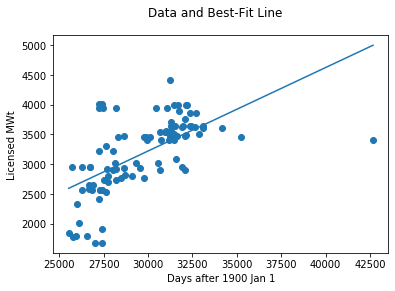

In [8]:
# Taken from the LinearRegression notebook from class
def plot_best_fit_line(model, x, y):
    # create the figure
    fig = plt.figure(1)
    fig.suptitle('Data and Best-Fit Line')
    plt.xlabel('Days after 1900 Jan 1')
    plt.ylabel('Licensed MWt')

    # put the generated dataset points on the graph
    plt.scatter(x, y)
    
    # Now we actually want to plot the best-fit line.
    # To simulate that, we'll simply generate all the
    # inputs on the graph and plot that.
    # predict for inputs along the graph to find the best-fit line
    X = np.linspace(min(x)-10, max(x)+10) # generates all the possible values of x
    Y = model.predict(list(zip(X)))
    plt.plot(X, Y)

plot_best_fit_line(model, x, y)

We can find the `R^2` value for the line produced:

In [9]:
def r_squared(model, x, y):
    y_pred = np.array([model.predict([t]) for t in x])
    y_avg = np.average(y)
    return 1 - np.sum((y_pred-y)**2)/np.sum((y_avg-y)**2)

r_squared(model, x, y)

-132.03220255677556

We can remove the outlier at x ~ 42500 and retry (with Lasso regularization).

In [10]:
df2 = df.drop(df[df["Commercial Operation"] > 42500].index)
no_model = linear_model.Lasso(alpha=1)
no_x = np.array(df2["Commercial Operation"]).reshape(-1, 1)
no_y = np.array(df2["Licensed MWt"]).reshape(-1, 1)
no_model.fit(X=no_x, y=no_y)
print("Coef:", no_model.coef_[0], "Intercept:", no_model.intercept_)

Coef: 0.17991627842811506 Intercept: [-2137.86549243]


0.46149426685235273

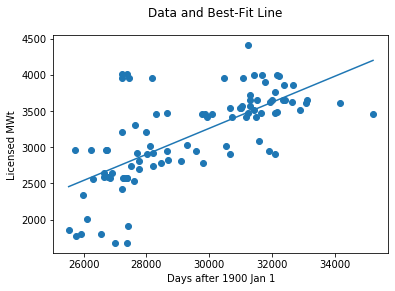

In [11]:
plot_best_fit_line(no_model, no_x, no_y)
r_squared(no_model, no_x, no_y)

In this case, a polynomial or logarithmic model may fit the data better due to the curved nature of the scatterplot.